In [27]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

from PIL import Image, ImageDraw
import face_recognition
import os

### Example

In [28]:
train_path = './data/train/'
test_path = './data/test/'

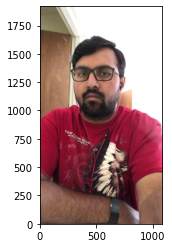

In [29]:
# flipping image so that it is upright
img = plt.imshow(plt.imread('./data/train/0_train/01_0/frame0.jpg'),
           origin='lower');

### Sequential Model

In [11]:
train_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

In [12]:
train_data = train_gen.flow_from_directory(
    train_path,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_path,
    class_mode='binary'
)

Found 70259 images belonging to 2 classes.
Found 14918 images belonging to 2 classes.


In [14]:
# Instantiate model
model = Sequential()

# add a convolutional layer
model.add(Conv2D(
   filters=16,
   kernel_size=(3,3),
   activation='relu' 
))

# Add pooling layer
model.add(MaxPool2D(
    pool_size=(2,2)
))

# Flatten image to 1-dimensional array
model.add(Flatten())

# 100 unit layer
model.add(Dense(
    units=100,
    activation='relu'
))

# output layer
model.add(Dense(
    units=1,
    activation='sigmoid'
))

# Compiling data
model.compile(
    loss='bce',
    metrics=['acc']
)

# Fit model on train_data
history = model.fit(
    train_data,
    batch_size = 32,
    validation_data=test_data,
    validation_batch_size=32,
    epochs=5
)

2022-10-14 08:41:30.592134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
2196/2196 [==============================] - 2965s 1s/step - loss: 0.2690 - acc: 0.9801 - val_loss: 2.4841 - val_acc: 0.6243
Epoch 2/5
2196/2196 [==============================] - 2769s 1s/step - loss: 0.0298 - acc: 0.9970 - val_loss: 2.3643 - val_acc: 0.6705
Epoch 3/5
2196/2196 [==============================] - 2775s 1s/step - loss: 0.0276 - acc: 0.9977 - val_loss: 4.6297 - val_acc: 0.6459
Epoch 4/5
2196/2196 [==============================] - 2705s 1s/step - loss: 0.0159 - acc: 0.9987 - val_loss: 4.3290 - val_acc: 0.6388
Epoch 5/5
2196/2196 [==============================] - 3069s 1s/step - loss: 0.0147 - acc: 0.9988 - val_loss: 4.4248 - val_acc: 0.6209


In [15]:
train_preds = model.predict(train_data)
test_preds = model.predict(test_data)

467/467 [==============================] - 341s 730ms/step


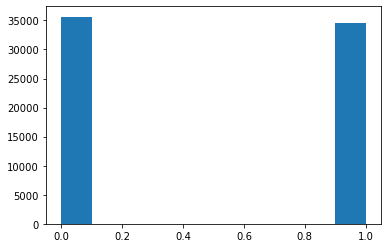

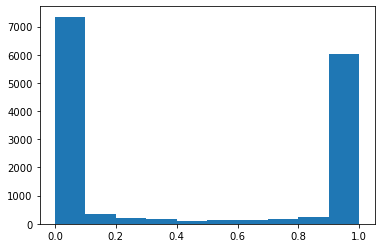

In [16]:
plt.hist(train_preds);
plt.show()
plt.hist(test_preds);

In [17]:
score = model.evaluate(test_data, 
                       verbose=1)

467/467 [==============================] - 355s 761ms/step - loss: 4.4248 - acc: 0.6209


In [18]:
labels = model.metrics_names
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

loss: 4.424814701080322
acc: 0.6208606958389282


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 16)   0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 100)               25806500  
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 25,807,049
Trainable params: 25,807,049
Non-trainable params: 0
____________________________________________

### EfficientNet

In [20]:
train_gen_eff = ImageDataGenerator()
test_gen_eff = ImageDataGenerator()

train_data_eff = train_gen_eff.flow_from_directory(
    train_path,
    class_mode='binary',
    # size must be set to 224x224 for EfficientNetB0
    target_size=(224,224)
)

test_data_eff = test_gen_eff.flow_from_directory(
    test_path,
    class_mode='binary',
    # size must be set to 224x224 for EfficientNetB0
    target_size=(224,224)
)


Found 70259 images belonging to 2 classes.
Found 14918 images belonging to 2 classes.


In [21]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')

In [22]:
effnet.trainable = False

In [23]:
model_eff = Sequential()
model_eff.add(effnet)

model_eff.add(GlobalAveragePooling2D())
model_eff.add(Dense(1, activation='sigmoid'))

In [24]:
model_eff.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='bce',
    metrics=['acc']
)

In [25]:
history_eff = model_eff.fit(
    train_data_eff,
    batch_size=64,
    validation_data=test_data_eff,
    validation_batch_size=64,
    epochs=10,
    verbose=1
)

Epoch 1/10
2196/2196 [==============================] - 4735s 2s/step - loss: 0.4216 - acc: 0.8432 - val_loss: 0.7487 - val_acc: 0.4954
Epoch 2/10
2196/2196 [==============================] - 4359s 2s/step - loss: 0.2228 - acc: 0.9644 - val_loss: 0.7617 - val_acc: 0.5402
Epoch 3/10
2196/2196 [==============================] - 4303s 2s/step - loss: 0.1407 - acc: 0.9863 - val_loss: 0.7963 - val_acc: 0.5615
Epoch 4/10
2196/2196 [==============================] - 4263s 2s/step - loss: 0.0968 - acc: 0.9921 - val_loss: 0.8364 - val_acc: 0.5669
Epoch 5/10
2196/2196 [==============================] - 4278s 2s/step - loss: 0.0697 - acc: 0.9950 - val_loss: 0.8813 - val_acc: 0.5680
Epoch 6/10
2196/2196 [==============================] - 4285s 2s/step - loss: 0.0529 - acc: 0.9961 - val_loss: 0.9118 - val_acc: 0.5729
Epoch 7/10
2196/2196 [==============================] - 4264s 2s/step - loss: 0.0410 - acc: 0.9971 - val_loss: 0.9498 - val_acc: 0.5705
Epoch 8/10
2196/2196 [==========================

### More Complicated Model

In [30]:
train_gen_2 = ImageDataGenerator()
test_gen_2 = ImageDataGenerator()

train_data_2 = train_gen_2.flow_from_directory(
    train_path,
    class_mode='binary',
    # size must be set to 224x224 for EfficientNetB0
    target_size=(224,224)
)

test_data_2 = test_gen_2.flow_from_directory(
    test_path,
    class_mode='binary',
    # size must be set to 224x224 for EfficientNetB0
    target_size=(224,224)
)


Found 70259 images belonging to 2 classes.
Found 14918 images belonging to 2 classes.


In [31]:
# Instantiate the model
model2 = Sequential()

# Adding first three convolutional layers
model2.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu', # activation function 
                ))
model2.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu' # activation function 
                ))
model2.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu' # activation function 
                ))

# Adding pooling after convolutional layers
model2.add(MaxPooling2D(pool_size = (2,2)))
# Dimensions of the region that you are pooling

# Adding second set of convolutional layers
model2.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu' # activation function 
                ))
model2.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu' # activation function 
                ))

# Add last pooling layer.
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# Adding first dense layer with 256 nodes
model2.add(Dense(256, activation='relu'))

# Adding a dropout layer to avoid overfitting
model2.add(Dropout(0.3))

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3)) 

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

# adding output layer
model2.add(Dense(1, activation = 'sigmoid'))

# compiling the model
model2.compile(loss='bce',
                optimizer='adam',
                metrics=['acc'])

# fitting the model
model2.fit(train_data_2,
          batch_size=128,
          validation_data=test_data_2,
          epochs=5)

# evaluate the model 
model2.evaluate(test_data_2, verbose=1)

Epoch 1/5
2196/2196 [==============================] - 8309s 4s/step - loss: 0.1483 - acc: 0.9796 - val_loss: 4.7233 - val_acc: 0.4609
Epoch 2/5
2196/2196 [==============================] - 8316s 4s/step - loss: 0.0172 - acc: 0.9964 - val_loss: 4.0750 - val_acc: 0.5512
Epoch 3/5
2196/2196 [==============================] - 8323s 4s/step - loss: 0.0503 - acc: 0.9926 - val_loss: 3.0270 - val_acc: 0.6538
Epoch 4/5
2196/2196 [==============================] - 8178s 4s/step - loss: 0.0233 - acc: 0.9943 - val_loss: 7.4525 - val_acc: 0.5857
Epoch 5/5
467/467 [==============================] - 529s 1s/step - loss: 7.9892 - acc: 0.6001


[7.989151954650879, 0.6000804305076599]